# Study state-of-the-art method to analyze the internals of a neural network

Performing a gradient analysis is (at least in the field of computer vision) the simpelst analysis you can do to reason about the workings of a neural network. Many other methods have been proposed in the recent literature. Luckily, the project [iNNvestigate](https://github.com/albermax/innvestigate) provides reference implementations for most of the popular methods and provides easy access to the sometimes rather complex algorithms.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
import innvestigate

Using TensorFlow backend.


## Set up the VGG16 model

Such as done in the last example, we set up the VGG16 and perform a classification on the input image.

Rank: 1, Label: Persian_cat, Score: 0.451
Rank: 2, Label: Siamese_cat, Score: 0.314
Rank: 3, Label: lynx, Score: 0.069
Rank: 4, Label: tabby, Score: 0.041
Rank: 5, Label: computer_keyboard, Score: 0.015


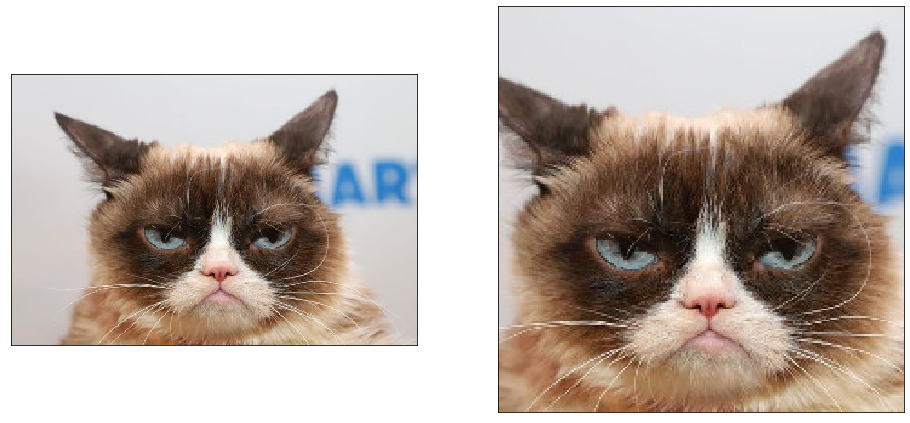

In [2]:
# Load the VGG16 model
model = VGG16()

# Define the cropping function
def center_crop(img, new_width=224, new_height=224):
    width = img.shape[1]
    height = img.shape[0]
    
    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))
    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))
    
    if any(np.array([left, right, top, bottom]) < 0):
        raise Exception("Cropped image has to be exactly of size 224x224. Your input image is too small.")

    return img[top:bottom, left:right]

# Load the input image, convert to a numpy array and crop the image
img = load_img('cat.jpg')
imgarr = img_to_array(img)
imgarr = center_crop(imgarr)

# Plot the original image and the cropped version
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(imgarr.astype(np.uint8))

# Preprocess the image
imgarr_preproc = np.expand_dims(imgarr.copy(), axis=0)
imgarr_preproc = preprocess_input(imgarr_preproc)

# Perform the classification
pred = model.predict(imgarr_preproc)
labels = decode_predictions(pred, top=5)

# Print the top 5 classifications
for i, label in enumerate(labels[0]):
    print("Rank: {:}, Label: {:}, Score: {:.3f}".format(i + 1, label[1], label[2]))

## Study the response of different methods

You can find the list of implemented methods in the source code [here](https://github.com/albermax/innvestigate/blob/master/innvestigate/analyzer/__init__.py#L66-L115).

The repository also contains examples in notebooks comparing the different methods on either different images or different architectures:

* [Compare methods based on different images](https://github.com/albermax/innvestigate/blob/master/examples/notebooks/imagenet_compare_methods.ipynb)
* [Compare methods based on different models](https://github.com/albermax/innvestigate/blob/master/examples/notebooks/imagenet_compare_networks.ipynb)

To gather first-hand experience with the algorithms, study the example below.

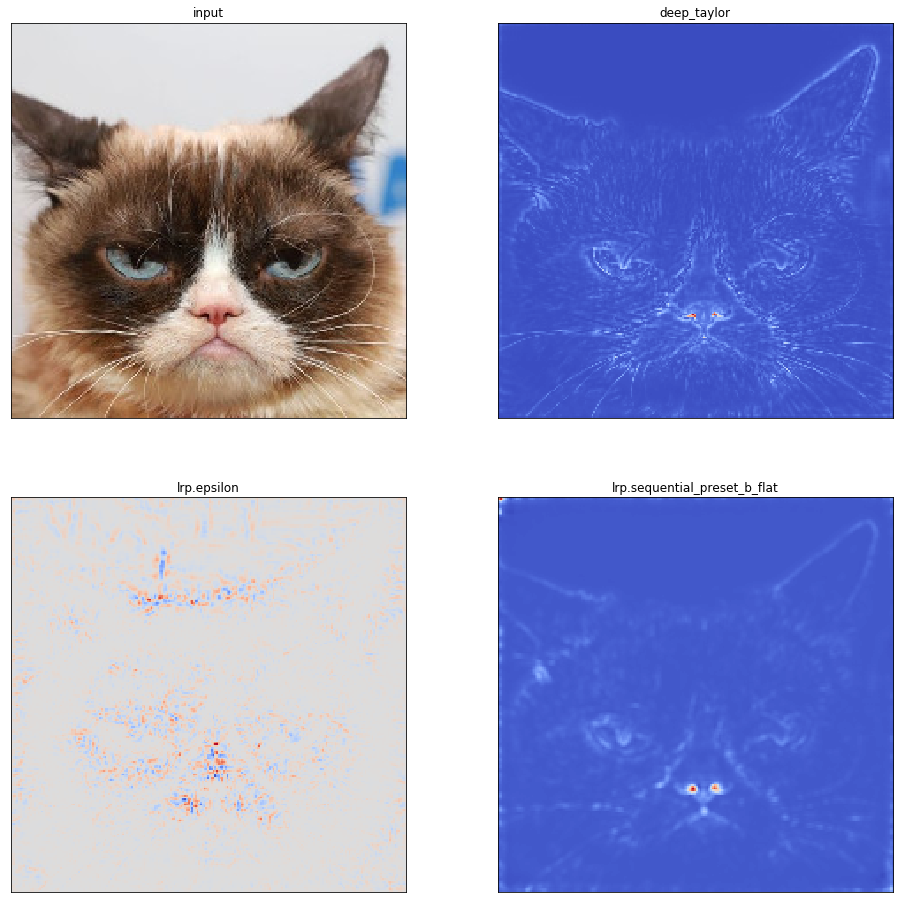

In [3]:
# Convert the Keras model to a model without the final softmax because
# such a model is needed for most of the methods
model2 = innvestigate.utils.model_wo_softmax(model)

# Declare a set of analyzers to be studied
analyzers = {}
analyzers["deep_taylor"] = innvestigate.create_analyzer("deep_taylor", model2)
analyzers["lrp.epsilon"] = innvestigate.create_analyzer("lrp.epsilon", model2)
analyzers["lrp.sequential_preset_b_flat"] = innvestigate.create_analyzer("lrp.sequential_preset_b_flat", model2)

# Plot the input image
size = np.ceil(np.sqrt(len(analyzers)))
plt.figure(figsize=(16, 16))
plt.subplot(size, size, 1)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.title("input")
plt.imshow(imgarr.astype(np.uint8))

# Compare and plot the result of the analyzers
for i, method in enumerate(analyzers):
    a = analyzers[method].analyze(imgarr_preproc)
    a = np.mean(a, axis=-1).squeeze()
    a = (a - a.max()) / (a.max() - a.min())
    plt.subplot(size, size, i + 2)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.title(method)
    plt.imshow(a, cmap="coolwarm")

## Comparison to edge detection

Are these methods just fancy edge detectors ([Sanity Checks for Saliency Maps](https://arxiv.org/pdf/1810.03292.pdf))?

Methods for edge detection, for example using Sobel filters, do not need any information about the content of the image.

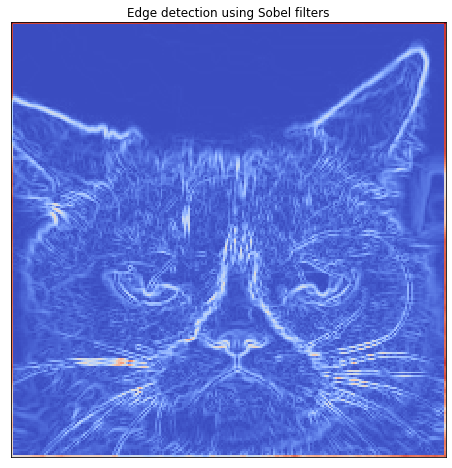

In [4]:
img_grayscale = np.mean(imgarr, axis=-1)
sobx = ndimage.sobel(img_grayscale, axis=0, mode='constant')
soby = ndimage.sobel(img_grayscale, axis=1, mode='constant')
sob = np.sqrt(sobx**2 + soby**2)
sob = (sob - sob.min()) / (sob.max() - sob.min())

plt.figure(figsize=(8, 8))
plt.title("Edge detection using Sobel filters")
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(sob, cmap="coolwarm");